# Project 3: Web APIs & Classification


## Problem Statement:


My startup has created an application that allows consumers to view more information about alcoholic beverage by hovering their phone camera over the bottle. To further improve our application, we wanted to expand the use of our machine learning algorithm and find a way to classify human-generated content, so we can provide suggestions about the drink consumers were referring to. Given that we can gather data from Reddit, our objective now is to find which classification model is best at differentiating beer subreddit posts from wine subreddit posts as these are our targeted alcohol categories. 

The two classifier model that will be constructed are Multinomial Naive Bayes model and Logistic Regression model. The evaluation metric that will be used is Accuracy as both models need to correctly classify posts into the respective subreddits.

## Executive Summary: 

I started off the project by gathering the two subreddit posts: beer and wine. Once I gathered enough dataset (minimum 1,000 posts per each subreddit) I concatenated the two columns that I will evaluate (title and selftext) and started looking at size and general information of the datasets. I began cleaning the dataset by dropping the null values and duplicate values as these are small percentages of the total data. I explored the data visualization in terms of length of title, posting time, and common words. The visualization provided the insights between beer subreddit and wine subreddit.

Then, I preprocessed the data by removing HTML, http, https, commonly used domains, non-letter characters, stopwords, and other special characters. I also converted the data into lowercase and later lemmatized the text. After I merged and saved the cleaned data into one CSV file, I started working on modeling section. I used train/test split to fit both datasets to one another. Then, I used CountVectorizer to transform text and calculated baseline accuracy as a benchmark since accuracy is the evaluation metric for my models. I created two classifier models: Logistic Regression and Multinomial Naive Bayes model as well as confusion matrix for each model. Although using the default hyperparameters give me a good results (more than 90% accuracy), I tried fine-tuning the models by adjusting other hyperparameters and using TFIDF vectorizer as well. However, compared the accuracy score between all of the tuned models, I found that the original Multinomial Naive Bayes model still gives the best accuracy score of 94.3%. Therefore, I concluded that the best model for my Startup to proceed for further development would be Multinomial Naive Bayes model with default hyperparameters.


## Contents:
- Data Collection
- Data Cleaning
- Exploratory Data Analysis
- Preprocessing
- Modeling
- Conclusion and Recommendation

In [1]:
#import libraries
import requests
import re
import random
import json
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bs
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

%matplotlib inline

## Data Collection

### Gather beer subreddits

In [2]:
#create a function to gather data from subreddits
def reddit(url,loop):
    
    posts = []
    after = None
    new_df = 'new_df'
    name = re.search('r\/(.+).json',url).group(1)
    
    for i in range(loop):
        if after == None: 
            current_url = url
        else:
            current_url = url + '?after=' + after
        print(current_url)
        res = requests.get(current_url, headers={'User-agent': 'Bleep blorp bot 0.1'})
        
        if res.status_code != 200:
            print('Status error', res.status_code)
            break
    
        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        after = current_dict['data']['after']
    
        if i > 0:
            prev_posts = pd.read_csv('./datasets/' + name + '.csv')
            current_df = pd.DataFrame(current_posts)
            new_df = pd.concat([prev_posts, current_df])
            new_df.to_csv('./datasets/' + name + '.csv', index=False)
        else:
            pd.DataFrame(posts).to_csv('./datasets/' + name + '.csv', index = False)

        # generate a random sleep duration to look more 'natural'
        sleep_duration = random.randint(2,6)
        print(sleep_duration)
        time.sleep(sleep_duration)
    
    return new_df

First, I will gather beer subreddits using the reddit function I just created. 

In [3]:
#gather beer subreddits using reddit function 
#input 45 loops as we only get 25 posts per loop and I want at least 1000 posts per each subreddit
reddit('https://www.reddit.com/r/beer.json', 45)

https://www.reddit.com/r/beer.json
4
https://www.reddit.com/r/beer.json?after=t3_m8gpob
6
https://www.reddit.com/r/beer.json?after=t3_m6rfcl
2
https://www.reddit.com/r/beer.json?after=t3_m515r0
3
https://www.reddit.com/r/beer.json?after=t3_m3rkss
6
https://www.reddit.com/r/beer.json?after=t3_m1k1e7
2
https://www.reddit.com/r/beer.json?after=t3_lyfmrv
6
https://www.reddit.com/r/beer.json?after=t3_ly5lxf
6
https://www.reddit.com/r/beer.json?after=t3_lwddyq
6
https://www.reddit.com/r/beer.json?after=t3_lsv46e
4
https://www.reddit.com/r/beer.json?after=t3_lqywmr
4
https://www.reddit.com/r/beer.json?after=t3_loi3ge
5
https://www.reddit.com/r/beer.json?after=t3_llz1pq
6
https://www.reddit.com/r/beer.json?after=t3_lj5cn5
4
https://www.reddit.com/r/beer.json?after=t3_lhl7mx
3
https://www.reddit.com/r/beer.json?after=t3_lfqnwg
2
https://www.reddit.com/r/beer.json?after=t3_ldmrag
2
https://www.reddit.com/r/beer.json?after=t3_lcjw43
2
https://www.reddit.com/r/beer.json?after=t3_laqvzu
6
https://w

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,post_hint,preview,link_flair_template_id,url_overridden_by_dest,poll_data,author_cakeday,crosspost_parent_list,crosspost_parent
0,NaN,beer,"Hi, Howdy, Hello! No doubt you’re here because...",t2_7zg7o,False,NaN,0,False,Beer Suggestions on r/beer And You: So You Wan...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,beer,Do you have questions about beer? We have answ...,t2_6l4z3,False,NaN,0,False,No Stupid Questions Wednesday - ask anything a...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,beer,When I first got into craft beer 10 years ago ...,t2_n6c0bj0,False,NaN,0,False,Just found out Otter Creek brought back the Co...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,beer,I've had a [Kellerbier](https://www.beeradvoca...,t2_5vlmpop0,False,NaN,0,False,What are some beer styles that you wish craft ...,[],...,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,beer,Was never a big Geuze fan but always loved Bel...,t2_3jib57se,False,NaN,0,False,A beer that changed your mind about a style,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,None,beer,Hey you guys\n\nSo this might not be the typic...,t2_6ef5r,False,None,0,False,Cornhole beer box design,[],...,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,None,beer,"I see $10-20 at a brewery, higher up to $75 fo...",t2_ctmwf,False,None,0,False,Why is glassware so expensive?,[],...,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,None,beer,EDIT: damn this post blew up! Sorry all for di...,t2_9od2nnap,False,None,0,False,"What beer do people like to ""shit on"" but is a...","[{'e': 'text', 't': 'Yinlin'}]",...,None,False,NaN,NaN,76619e16-c44d-11e7-ade6-0eb84b5e8912,NaN,NaN,NaN,NaN,NaN
23,None,beer,,t2_9za0b32m,False,None,0,False,Favorite Beer associated with a country? Red S...,[],...,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


My beer subreddit data has 1124 rows and 112 columns. Now I will save the data into CSV file.

In [4]:
#save the data into CSV file
beer = pd.read_csv('datasets/beer.csv')

In [5]:
#show title and selftext of the first post
beer[['title','selftext']].loc[0]

title       Beer Suggestions on r/beer And You: So You Wan...
selftext    Hi, Howdy, Hello! No doubt you’re here because...
Name: 0, dtype: object

### Gather wine subreddit

Now, I will gather wine subreddit using the reddit function.

In [6]:
#gather wine subreddits using reddit function
#input 45 loops as we only get 25 posts per loop and I want at least 1000 posts per each subreddit
reddit('https://www.reddit.com/r/wine.json', 45)

https://www.reddit.com/r/wine.json
6
https://www.reddit.com/r/wine.json?after=t3_m9mok7
4
https://www.reddit.com/r/wine.json?after=t3_m8sbg4
4
https://www.reddit.com/r/wine.json?after=t3_m8mg0p
2
https://www.reddit.com/r/wine.json?after=t3_m7jnm3
5
https://www.reddit.com/r/wine.json?after=t3_m6iqwv
6
https://www.reddit.com/r/wine.json?after=t3_m663jh
6
https://www.reddit.com/r/wine.json?after=t3_m5byns
2
https://www.reddit.com/r/wine.json?after=t3_m4mfwy
6
https://www.reddit.com/r/wine.json?after=t3_m3vpzq
2
https://www.reddit.com/r/wine.json?after=t3_m3vgwt
2
https://www.reddit.com/r/wine.json?after=t3_m2tt8f
2
https://www.reddit.com/r/wine.json?after=t3_m29zrz
4
https://www.reddit.com/r/wine.json?after=t3_m13m4r
5
https://www.reddit.com/r/wine.json?after=t3_lzs8os
4
https://www.reddit.com/r/wine.json?after=t3_lzijhq
2
https://www.reddit.com/r/wine.json?after=t3_lyl9gy
6
https://www.reddit.com/r/wine.json?after=t3_lyrxaw
2
https://www.reddit.com/r/wine.json?after=t3_lxx8p6
4
https://w

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,url_overridden_by_dest,is_gallery,media_metadata,gallery_data,poll_data,crosspost_parent_list,crosspost_parent,author_cakeday
0,NaN,wine,"Hi Everyone!\n\nSorry for being a day late, bu...",t2_b8geq,False,NaN,0,False,**Monthly Wine Challenge - March 2021 Tasting ...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,wine,"Bottle porn without notes, random musings, off...",t2_6l4z3,False,NaN,0,False,Free Talk Friday,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,wine,NaN,t2_4e0wb2d0,False,NaN,0,False,A Couple of Old Alsatian Bottles: 1976 René Kl...,[],...,NaN,False,https://i.redd.it/mc7tjs9pfdo61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,wine,NaN,t2_5cnh66nr,False,NaN,0,False,Sine Qua Non The Raven Syrah 2006,[],...,NaN,False,https://www.reddit.com/gallery/ma2cl2,True,"{'sb7mst2b9fo61': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'sb7mst2b9fo61', 'id':...",NaN,NaN,NaN,NaN
4,NaN,wine,NaN,t2_c1jfi,False,NaN,1,False,Still thinking about this one from last night....,[],...,NaN,False,https://i.redd.it/q3cyphtxaeo61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,None,wine,"Hello fellow vino's, we are looking for option...",t2_98de2xah,False,None,0,False,Chardonnay monthly subscription,[],...,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,None,wine,"Hi all,\nCan you brew 2x 1 gallon wine kits in...",t2_ww536,False,None,0,False,Brew 2 gallon in 3 gallon Fermentation jar,[],...,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,None,wine,,t2_44ahpv7o,False,None,0,False,Chateau Lynch Bages Grand Cru 2006,[],...,None,False,https://i.redd.it/4zdr7t1evin61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,None,wine,"Hello folks, \n\n\nI own a board game cafe in...",t2_d2bs6,False,None,0,False,Wine Suggestions for Game Cafe - Bottles or wi...,[],...,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


My wine dataset has 1114 rows and 114 columns. Now I will save the data into CSV file.

In [7]:
#save the data into CSV file
wine = pd.read_csv('datasets/wine.csv')

In [8]:
#show title and self text of the first post
wine[['title','selftext']].loc[0]

title       **Monthly Wine Challenge - March 2021 Tasting ...
selftext    Hi Everyone!\n\nSorry for being a day late, bu...
Name: 0, dtype: object

## Data Cleaning

### Clean beer subreddit data

In [9]:
#show first five rows of beer details
beer.head(5)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,post_hint,preview,link_flair_template_id,url_overridden_by_dest,poll_data,author_cakeday,crosspost_parent_list,crosspost_parent
0,NaN,beer,"Hi, Howdy, Hello! No doubt you’re here because...",t2_7zg7o,False,NaN,0,False,Beer Suggestions on r/beer And You: So You Wan...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,beer,Do you have questions about beer? We have answ...,t2_6l4z3,False,NaN,0,False,No Stupid Questions Wednesday - ask anything a...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,beer,When I first got into craft beer 10 years ago ...,t2_n6c0bj0,False,NaN,0,False,Just found out Otter Creek brought back the Co...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,beer,I've had a [Kellerbier](https://www.beeradvoca...,t2_5vlmpop0,False,NaN,0,False,What are some beer styles that you wish craft ...,[],...,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,beer,Was never a big Geuze fan but always loved Bel...,t2_3jib57se,False,NaN,0,False,A beer that changed your mind about a style,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Look at title and self text columns
beer[['title', 'selftext']]

,title,selftext
0,Beer Suggestions on r/beer And You: So You Wan...,"Hi, Howdy, Hello! No doubt you’re here because..."
1,No Stupid Questions Wednesday - ask anything a...,Do you have questions about beer? We have answ...
2,Just found out Otter Creek brought back the Co...,When I first got into craft beer 10 years ago ...
3,What are some beer styles that you wish craft ...,I've had a [Kellerbier](https://www.beeradvoca...
4,A beer that changed your mind about a style,Was never a big Geuze fan but always loved Bel...
...,...,...
1119,Cornhole beer box design,Hey you guys\n\nSo this might not be the typic...
1120,Why is glassware so expensive?,"I see $10-20 at a brewery, higher up to $75 fo..."
1121,"What beer do people like to ""shit on"" but is a...",EDIT: damn this post blew up! Sorry all for di...
1122,Favorite Beer associated with a country? Red S...,NaN


Since 'title' and 'selftext' columns have the most relevant content to be used for classificaion and generate features for CountVectorization, we will concatenate both columns to help with feature generation.

In [11]:
#concatenate title and self text together into one column "text"
beer_merged = pd.concat([beer['title'], beer['selftext']], axis=0)
beer_merged = pd.DataFrame(beer_merged, columns=['text'])
beer_merged.head()

,text
0,Beer Suggestions on r/beer And You: So You Wan...
1,No Stupid Questions Wednesday - ask anything a...
2,Just found out Otter Creek brought back the Co...
3,What are some beer styles that you wish craft ...
4,A beer that changed your mind about a style


Let's drop duplicate posts and null values. 

In [12]:
#drop duplicate posts
beer_merged = beer_merged.drop_duplicates(subset=['text'])
beer_merged

,text
0,Beer Suggestions on r/beer And You: So You Wan...
1,No Stupid Questions Wednesday - ask anything a...
2,Just found out Otter Creek brought back the Co...
3,What are some beer styles that you wish craft ...
4,A beer that changed your mind about a style
...,...
992,The Peppermint is strong with this one!\n\n[ht...
993,"Hi all.\n\nI've ""accidentally"" bought a bottle..."
994,"I thought I'd splash out this Christmas, what ..."
995,"Preramble\n\nI know, I'm probably a rube for e..."


In [13]:
#check for null values
beer_merged.isnull().sum()

text    1
dtype: int64

In [14]:
#drop 1 null value since it is just one data point out of 1639
beer_merged.dropna(inplace=True)

In [17]:
#check beer shape again
beer_merged.shape

(1638, 1)

After checking wine_merged dataset down below, I found that wine dataset has 1347 data points while beer dataset has 1638 data points. To ensure that my dataset will not be bias, I will only use 1347 data points out of 1638 beer dataset to be used for my future analysis.

In [24]:
beer_merged = beer_merged.sample(n=1347)
beer_merged

,text
572,"Hello everyone, \n\nI would like to know where..."
591,For my fellow Foothills drinkers
135,Resources for obtaining international beers
234,What is the cheapest craft beer website that s...
160,I'm located in the Twin Cities metro in MN\n\n...
...,...
540,If anyone knows your more than welcome to leav...
671,"Also, I’m currently in Texas lol"
286,"So, who are the animals here that drink Guinne..."
781,Anybody got any quick tips for reducing carbon...


Now, beer dataset is ready for EDA.

### Clean wine subreddit data

In [16]:
#show first five rows of wine
wine.head(5)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,url_overridden_by_dest,is_gallery,media_metadata,gallery_data,poll_data,crosspost_parent_list,crosspost_parent,author_cakeday
0,NaN,wine,"Hi Everyone!\n\nSorry for being a day late, bu...",t2_b8geq,False,NaN,0,False,**Monthly Wine Challenge - March 2021 Tasting ...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,wine,"Bottle porn without notes, random musings, off...",t2_6l4z3,False,NaN,0,False,Free Talk Friday,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,wine,NaN,t2_4e0wb2d0,False,NaN,0,False,A Couple of Old Alsatian Bottles: 1976 René Kl...,[],...,NaN,False,https://i.redd.it/mc7tjs9pfdo61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,wine,NaN,t2_5cnh66nr,False,NaN,0,False,Sine Qua Non The Raven Syrah 2006,[],...,NaN,False,https://www.reddit.com/gallery/ma2cl2,True,"{'sb7mst2b9fo61': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'sb7mst2b9fo61', 'id':...",NaN,NaN,NaN,NaN
4,NaN,wine,NaN,t2_c1jfi,False,NaN,1,False,Still thinking about this one from last night....,[],...,NaN,False,https://i.redd.it/q3cyphtxaeo61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#Look at title and self text columns
wine[['title', 'selftext']]

,title,selftext
0,**Monthly Wine Challenge - March 2021 Tasting ...,"Hi Everyone!\n\nSorry for being a day late, bu..."
1,Free Talk Friday,"Bottle porn without notes, random musings, off..."
2,A Couple of Old Alsatian Bottles: 1976 René Kl...,NaN
3,Sine Qua Non The Raven Syrah 2006,NaN
4,Still thinking about this one from last night....,NaN
...,...,...
1109,Chardonnay monthly subscription,"Hello fellow vino's, we are looking for option..."
1110,Brew 2 gallon in 3 gallon Fermentation jar,"Hi all,\nCan you brew 2x 1 gallon wine kits in..."
1111,Chateau Lynch Bages Grand Cru 2006,NaN
1112,Wine Suggestions for Game Cafe - Bottles or wi...,"Hello folks, \n\n\nI own a board game cafe in..."


Again, since 'title' and 'selftext' columns have the most relevant content to be used for classificaion and generate features for CountVectorization, we will concatenate both columns to help with feature generation.

In [19]:
#concatenate title and self text together into one column
wine_merged = pd.concat([wine['title'], wine['selftext']], axis=0)
wine_merged = pd.DataFrame(wine_merged, columns=['text'])
wine_merged.head()

,text
0,**Monthly Wine Challenge - March 2021 Tasting ...
1,Free Talk Friday
2,A Couple of Old Alsatian Bottles: 1976 René Kl...
3,Sine Qua Non The Raven Syrah 2006
4,Still thinking about this one from last night....


We will also drop duplicate posts and null values in this dataset.

In [20]:
#drop duplicate posts
wine_merged = wine_merged.drop_duplicates(subset=['text'])
wine_merged

,text
0,**Monthly Wine Challenge - March 2021 Tasting ...
1,Free Talk Friday
2,A Couple of Old Alsatian Bottles: 1976 René Kl...
3,Sine Qua Non The Raven Syrah 2006
4,Still thinking about this one from last night....
...,...
970,Hello I was wondering which of [these](https:/...
974,"Just put some in my ember mug, and I have to s..."
979,"Hi Vinos,\n\nI’m looking for an app to practic..."
981,Hello! So I finally have a wine cabinet where ...


In [21]:
#check for null values
wine_merged.isnull().sum()

text    1
dtype: int64

In [22]:
#drop 1 null value since it is just one data point out of 1345
wine_merged.dropna(inplace=True)

In [23]:
#check wine shape again
wine_merged.shape

(1347, 1)

Now, wine dataset is also ready for EDA.

## Exploratory Data Analysis

### EDA on beer dataset

### 1. Frequency of words

To find out the frequency of words, I will first split the text into list of words. Then, create a dictionary to input frequency of those words.

In [25]:
#split all the text in the beer dataset into list of words
list_of_words = " ".join(beer_merged.text).split()
list_of_words

['Hello',
 'everyone,',
 'I',
 'would',
 'like',
 'to',
 'know',
 'where',
 'do',
 'IPAs',
 'get',
 'their',
 'fruity',
 'flavor',
 'from.',
 "I'm",
 'not',
 'talking',
 'about',
 'IPAs',
 'in',
 'whose',
 'brewing',
 'process',
 'real',
 'fruit',
 'is',
 'added.',
 'Is',
 'it',
 'possible',
 'for',
 'IPAs',
 '(like',
 "Brewdog's",
 'Punk',
 'IPA)',
 'to',
 'have',
 'strong',
 'fruity',
 'flavors',
 '(I',
 'mostly',
 'feel',
 'notes',
 'of',
 'peach)',
 'by',
 'relying',
 'mostly',
 'on',
 'the',
 'Hops?',
 'Or',
 'does',
 'that',
 'fruity',
 'flavor',
 'actually',
 'require',
 'the',
 'usage',
 'of',
 'fruit',
 'in',
 'the',
 'process?',
 'Thank',
 'you',
 'in',
 'advance',
 'For',
 'my',
 'fellow',
 'Foothills',
 'drinkers',
 'Resources',
 'for',
 'obtaining',
 'international',
 'beers',
 'What',
 'is',
 'the',
 'cheapest',
 'craft',
 'beer',
 'website',
 'that',
 'ships',
 'to',
 'the',
 'UK?',
 "I'm",
 'located',
 'in',
 'the',
 'Twin',
 'Cities',
 'metro',
 'in',
 'MN',
 "I'd",
 '

In [26]:
#create a dictionary to find out frequency of words
mydict = {}
for word in list_of_words:
    if word in mydict:
        mydict[word] = mydict[word] + 1
    else:
        mydict[word] = 1

In [27]:
#find out what word shows up most frequently
max(mydict, key=mydict.get)

'I'

In [28]:
#sorting the words frequency in descending order
sort_freq = sorted(mydict.items(), key=lambda x: x[1], reverse=True)

for i in sort_freq[:10]:
    print(i[0], i[1])

I 1579
the 1555
a 1504
to 1392
and 1146
of 867
in 732
beer 636
it 585
for 569


We found that the words that show up most frequently are more of general vocabulary. These generic words will need to be removed in order to find better keywords for our subreddit.

### 2. Length of Title

I will find out the length of the title via character, sort the length and plot histogram to see the distribution of title length.

In [29]:
#find the length of title first
beer['title_length'] = [len(i) for i in beer['title']]
beer[['title', 'title_length']].head(10)

,title,title_length
0,Beer Suggestions on r/beer And You: So You Wan...,76
1,No Stupid Questions Wednesday - ask anything a...,55
2,Just found out Otter Creek brought back the Co...,54
3,What are some beer styles that you wish craft ...,73
4,A beer that changed your mind about a style,43
5,Smallest brewery Fort Collins CO,32
6,Beer with purpose,17
7,I just found Not Your Father's Root Beer in th...,69
8,Is grapefruit leinenkugel gone?,31
9,Has anyone ever seen Negra Modelo in 12oz cans?,47


In [30]:
#sort length of title
beer["title_length"].sort_values(ascending=False).head()

587    296
981    290
798    289
128    287
887    282
Name: title_length, dtype: int64

In [31]:
#check post index 558 
beer["title"][587]

"I have a bit of a strange situation, is anybody else like this? I feel opposite to most beer drinkers, at least in North America, if I drink warm/room temp beer I feel alright, but if I drink ice cold beer, my stomach feels heavy and I feel full and like I'm going to vomit. Anybody else like me?"

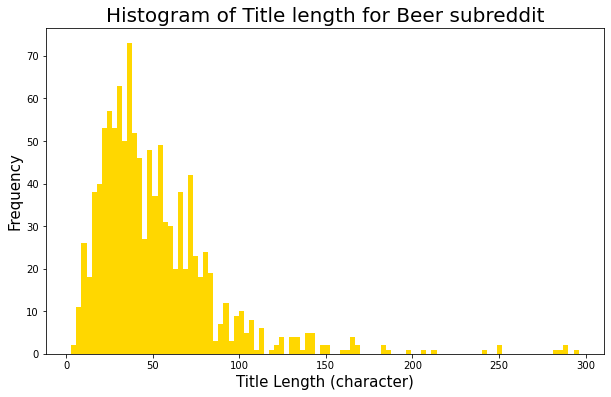

In [32]:
#Plot histogram to visualize the length of title
plt.figure(figsize=(10,6))
plt.hist(beer["title_length"], bins = 100, color='gold')
plt.title("Histogram of Title length for Beer subreddit", fontsize=20)
plt.xlabel("Title Length (character)", fontsize=15)
plt.ylabel("Frequency", fontsize=15);

The histogram shows frequency distribution of the title length. Clearly, beer subreddit has heavy right-skewed graph with majority of titles have around 25-75 characters (approximately 12-30 words). 

### 3. Time of the post

To look at the time that user posted, I search for columns that related to time in my dataset, drop duplicate values, and convert the column into datatime. Then, I create a bar chart to show the hours that the user posted.

In [33]:
#search for columns related to time zone
beer.columns[beer.columns.str.contains('utc|time|created')]

Index(['approved_at_utc', 'created', 'banned_at_utc', 'created_utc'], dtype='object')

In [34]:
#drop the duplicates first
beer_time = beer[['title','selftext','created_utc']].drop_duplicates(subset=['selftext']).drop(['title','selftext'], axis=1)
beer_time

,created_utc
0,1.596151e+09
1,1.615986e+09
2,1.616356e+09
3,1.616297e+09
4,1.616359e+09
...,...
992,1.607405e+09
993,1.607365e+09
994,1.607358e+09
995,1.607319e+09


In [35]:
#convert to datatime
beer_time = pd.to_datetime(beer_time['created_utc'], unit='s')
beer_time

0     2020-07-30 23:09:44
1     2021-03-17 13:00:21
2     2021-03-21 19:48:32
3     2021-03-21 03:24:49
4     2021-03-21 20:29:18
              ...        
992   2020-12-08 05:20:39
993   2020-12-07 18:11:09
994   2020-12-07 16:13:15
995   2020-12-07 05:25:23
996   2020-12-07 19:20:42
Name: created_utc, Length: 698, dtype: datetime64[ns]

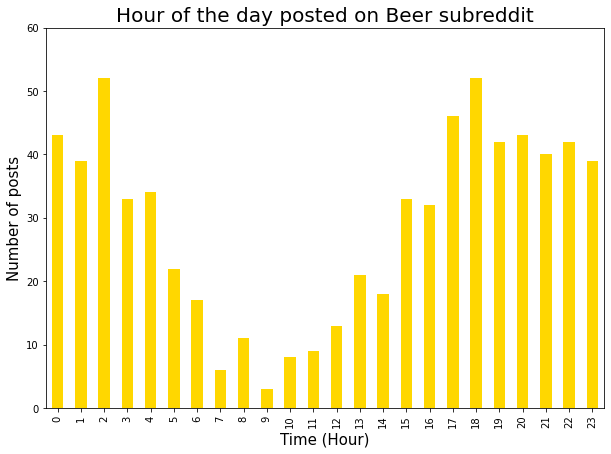

In [36]:
#create bar chart to show the hours that the user posted
beer_time.dt.hour.value_counts().sort_index().plot(kind='bar', figsize=(10,7), color='gold');
plt.title('Hour of the day posted on Beer subreddit', fontsize=20)
plt.xlabel("Time (Hour)", fontsize=15)
plt.ylabel("Number of posts", fontsize=15)
plt.axis([None, None, 0, 60]);

From the bar chart, the most popular time for posting on beer subreddit is 2am, followed by 5-6pm. In general, beer subreddit seems to be most active from 5pm to 2am.

### EDA on wine dataset

### 1. Frequency of words

To find out the frequency of words, I will first split the text into list of words. Then, create a dictionary to input frequency of those words.

In [37]:
#split all the text in the wine dataset into list of words
list_of_words = " ".join(wine_merged.text).split()
list_of_words

['**Monthly',
 'Wine',
 'Challenge',
 '-',
 'March',
 '2021',
 'Tasting',
 'Notes',
 'Post!**',
 'Free',
 'Talk',
 'Friday',
 'A',
 'Couple',
 'of',
 'Old',
 'Alsatian',
 'Bottles:',
 '1976',
 'René',
 'Klein',
 'Gewurztraminer,',
 'and',
 '1990',
 'Domaines',
 'Schlumberger',
 'Pinot',
 'Gris',
 'Kitterlé',
 'GC',
 'Sine',
 'Qua',
 'Non',
 'The',
 'Raven',
 'Syrah',
 '2006',
 'Still',
 'thinking',
 'about',
 'this',
 'one',
 'from',
 'last',
 'night...',
 '1988',
 'Don',
 'Melchor',
 'Chateau',
 'Siran',
 '1994',
 'Aveleda',
 'Alvarinho',
 'Cellar',
 'shots',
 'for',
 'u/Kirschkowitzki',
 'Trying',
 'to',
 'find',
 'a',
 'replacement',
 'for',
 'the',
 'champagne',
 'glass',
 'my',
 'friend',
 'broke.',
 'I',
 'believe',
 'it',
 'was',
 'gifted',
 'in',
 '2014',
 'from',
 'Pier',
 'One,',
 'but',
 'I’m',
 'having',
 'no',
 'luck',
 'finding',
 'it.',
 'Left',
 'bank',
 'Bordeaux',
 '[3/5]:',
 '2003',
 'Château',
 'Branaire-Ducru',
 'Chateauneuf',
 'du',
 'Pape',
 '1978',
 'Value?',
 '

In [38]:
#create a dictionary to find out frequency of words
mydict = {}
for word in list_of_words:
    if word in mydict:
        mydict[word] = mydict[word] + 1
    else:
        mydict[word] = 1

In [39]:
#find out what word shows up most frequently
max(mydict, key=mydict.get)

'a'

In [40]:
#sorting the words frequency in descending order
sort_freq = sorted(mydict.items(), key=lambda x: x[1], reverse=True)

for i in sort_freq[:10]:
    print(i[0], i[1])

a 1220
the 1073
I 1041
to 1033
and 916
of 681
for 555
wine 528
in 507
is 366


Similar to beer dataset, we found that the words that show up most frequently are more of general vocabulary. These generic words will need to be removed in order to find better keywords for our subreddit.

### 2. Length of Title

I will find out the length of the title via character, sort the length and plot histogram to see the distribution of title length.

In [41]:
#find the length of title first
wine['title_length'] = [len(i) for i in wine['title']]
wine[['title', 'title_length']].head(10)

,title,title_length
0,**Monthly Wine Challenge - March 2021 Tasting ...,59
1,Free Talk Friday,16
2,A Couple of Old Alsatian Bottles: 1976 René Kl...,119
3,Sine Qua Non The Raven Syrah 2006,33
4,Still thinking about this one from last night....,65
5,Chateau Siran 1994,18
6,Aveleda Alvarinho,17
7,Cellar shots for u/Kirschkowitzki,33
8,Trying to find a replacement for the champagne...,151
9,Left bank Bordeaux [3/5]: 2003 Château Branair...,53


In [42]:
#sort length of title
wine["title_length"].sort_values(ascending=False).head()

239     203
866     197
364     195
99      195
1086    195
Name: title_length, dtype: int64

In [43]:
#check post index 936
wine["title"][239]

'Does anyone know where I can buy the vertical and horizontal shelfs for the winner chiller EWC1201 (Powell 12 Bottle Single Zone Freestanding Wine Cooler with Adjustable Storage Options and LED Display).'

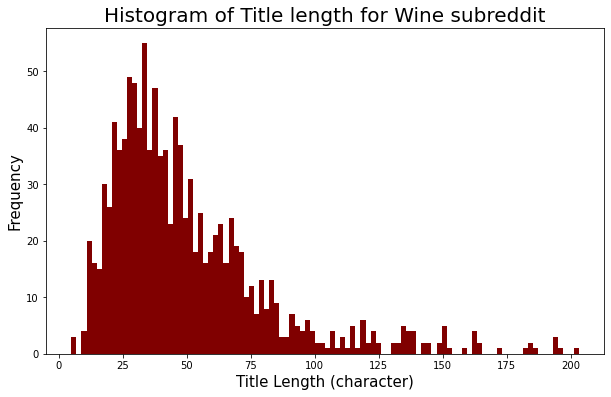

In [44]:
#Plot histogram to visualize the length of title
plt.figure(figsize=(10,6))
plt.hist(wine["title_length"], bins = 100, color='maroon')
plt.title("Histogram of Title length for Wine subreddit", fontsize=20)
plt.xlabel("Title Length (character)", fontsize=15)
plt.ylabel("Frequency", fontsize=15);

The histogram shows frequency distribution of the title length. Clearly, wine subreddit has heavy right-skewed graph with majority of titles have around 25-50 characters or approximately 10-25 words. Titles in wine subreddit seems to be shorter than those of beer subreddit, which have approximately 12-30 words in titles. With not significant difference in number of words in titles, both subreddits are similarly verbose.

### 3. Time of the post

To look at the time that user posted, I search for columns that related to time in my dataset, drop duplicate values, and convert the column into datatime. Then, I create a bar chart to show the hours that the user posted.

In [45]:
#search for columns related to time zone
wine.columns[wine.columns.str.contains('utc|time|created')]

Index(['approved_at_utc', 'created', 'banned_at_utc', 'created_utc'], dtype='object')

In [46]:
#drop the duplicates first
wine_time = wine[['title','selftext','created_utc']].drop_duplicates(subset=['selftext']).drop(['title','selftext'], axis=1)
wine_time

,created_utc
0,1.615938e+09
1,1.616130e+09
2,1.616328e+09
9,1.616331e+09
10,1.616365e+09
...,...
970,1.613347e+09
974,1.613342e+09
979,1.613335e+09
981,1.613333e+09


In [47]:
#convert to datatime
wine_time = pd.to_datetime(wine_time['created_utc'], unit='s')
wine_time

0     2021-03-16 23:45:24
1     2021-03-19 05:00:19
2     2021-03-21 12:01:18
9     2021-03-21 12:47:48
10    2021-03-21 22:13:13
              ...        
970   2021-02-14 23:48:28
974   2021-02-14 22:32:05
979   2021-02-14 20:35:55
981   2021-02-14 20:08:58
982   2021-02-14 19:46:31
Name: created_utc, Length: 365, dtype: datetime64[ns]

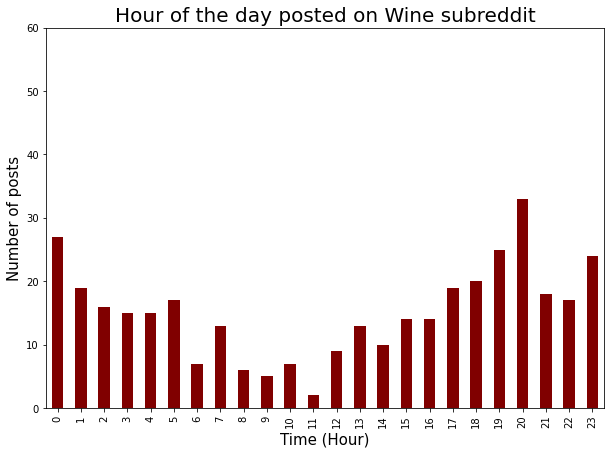

In [48]:
#create bar chart to show the hours that the user posted
wine_time.dt.hour.value_counts().sort_index().plot(kind='bar', figsize=(10,7), color='maroon');
plt.title('Hour of the day posted on Wine subreddit', fontsize=20)
plt.xlabel("Time (Hour)", fontsize=15)
plt.ylabel("Number of posts", fontsize=15)
plt.axis([None, None, 0, 60]);

From the above chart, the most popular time for posting on wine subreddit is 8pm, which is a lot earlier than the most popular time for posting on beer subreddit of 2am. Wine subreddit appears to be less active compared to beer subreddit as number of posts are under 20 posts per hour majority of the time while Beer subreddit has more 20 posts per hour majority of the time. 

## Preprocessing

Now, we are going to create preprocessing function and input our beer_merged dataset and wine_merged dataset into it to get th processed reddit post.

In [49]:
#create pre-processing function for our dataset

def review_to_words(df):
    new_list = []
    for raw_review in df:
        
    #Remove HTML.
        review_text = re.sub('\(https:.*?\)','', str(raw_review))
    
    #Remove substrings that start with 'https' or 'http'
        review_text = re.sub(r"((https)|(http))\S*", "", review_text)
        
    #Remove substrings with commonly used domains
        review_text = re.sub(r"(\S(?=.*(\.com|\.net|\.org|\.info))\S*)", "", review_text)
        
    #Remove slash and hyphens
        review_text = re.sub(r"(/s*\/*)|(\s-\s)", "", review_text)
        
    #Remove hyphenated numerals
        review_text = re.sub(r"[0-9]+-[0-9]+", "", review_text)

    #Remove new-line, tabs, carriage returns, and apostrophes that are followed by a space character
        review_text = re.sub(r"(\n\s+)|(\t\s+)|(\r\s+)|(\'\s+)", "", review_text)

    #Remove non-letters.
        letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    #Convert to lower case, split into individual words.
        words = letters_only.lower().split()
        
    #Convert the stopwords to a set.
        stops = set(stopwords.words('english'))
    
    #Remove stopwords.
        meaningful_words = [w for w in words if w not in stops]
                                                    
    #Lemmatizing as I want to keep the context and meaning of its base form
        lemmatizer = WordNetLemmatizer()
        old_list = []
                                       
        for word in meaningful_words:
            if not word in stops:
                old_list.append(lemmatizer.lemmatize(word))
                
    #Join the words back into one string separated by space
        new_list.append(" ".join(old_list))
     
    return new_list

### Preprocessing beer dataset

We are going to process beer_merged dataset using the review_to_words function we created. Then, we will create a bar chart showing the top common words in our dataset after removing generic words.

In [50]:
#preprocess beer_merged dataset
beer_merged['text'] = review_to_words(beer_merged['text'])
beer_merged

,text
572,hello everyone would like know ipas get fruity...
591,fellow foothill drinker
135,resource obtaining international beer
234,cheapest craft beer website ship uk
160,located twin city metro mni call seasoned ish ...
...,...
540,anyone know welcome leave link tell find
671,also currently texas lol
286,animal drink guinness fully settled
781,anybody got quick tip reducing carbonation tak...


In [51]:
#let's see frequency of words with more focused vocab
list_of_words_beer = " ".join(beer_merged.text).split()
list_of_words_beer

['hello',
 'everyone',
 'would',
 'like',
 'know',
 'ipas',
 'get',
 'fruity',
 'flavor',
 'talking',
 'ipas',
 'whose',
 'brewing',
 'process',
 'real',
 'fruit',
 'added',
 'possible',
 'ipas',
 'like',
 'brewdog',
 'punk',
 'ipa',
 'strong',
 'fruity',
 'flavor',
 'mostly',
 'feel',
 'note',
 'peach',
 'relying',
 'mostly',
 'hop',
 'fruity',
 'flavor',
 'actually',
 'require',
 'usage',
 'fruit',
 'process',
 'thank',
 'advance',
 'fellow',
 'foothill',
 'drinker',
 'resource',
 'obtaining',
 'international',
 'beer',
 'cheapest',
 'craft',
 'beer',
 'website',
 'ship',
 'uk',
 'located',
 'twin',
 'city',
 'metro',
 'mni',
 'call',
 'seasoned',
 'ish',
 'craft',
 'drinker',
 'recently',
 'fallen',
 'love',
 'belgian',
 'side',
 'thing',
 'tasty',
 'enough',
 'drinkable',
 'enough',
 'full',
 'flavored',
 'back',
 'throat',
 'sticky',
 'ipa',
 'feel',
 'smooth',
 'drinker',
 'really',
 'dig',
 'stuff',
 'along',
 'line',
 'leffe',
 'la',
 'chouffe',
 'hoegaarden',
 'delerium',
 'tr

In [52]:
#create a dictionary to find out frequency of words
mydict = {}
for word in list_of_words_beer:
    if word in mydict:
        mydict[word] = mydict[word] + 1
    else:
        mydict[word] = 1

In [53]:
#sorting the words frequency in descending order
sort_freq = sorted(mydict.items(), key=lambda x: x[1], reverse=True)

for i in sort_freq[:10]:
    print(i[0], i[1])

beer 1260
like 373
one 195
would 186
know 186
anyone 180
brewery 176
get 164
drink 159
good 152


In [54]:
#adding the frequency of words dictionary into a dataframe
beer_freq = pd.DataFrame(sort_freq, columns=['word','frequency'])
beer_freq

,word,frequency
0,beer,1260
1,like,373
2,one,195
3,would,186
4,know,186
...,...,...
5385,abvs,1
5386,pog,1
5387,settled,1
5388,reducing,1


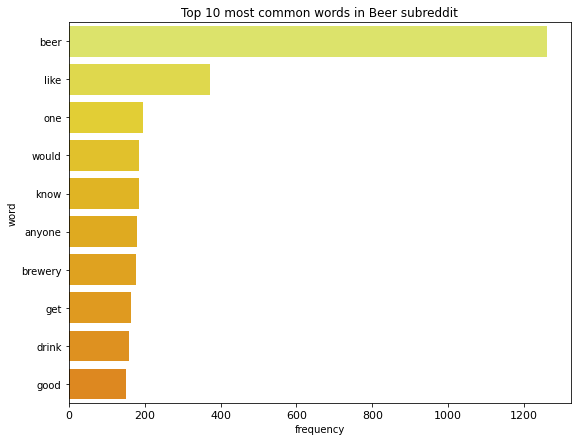

In [55]:
#create a bar chart for better visualization
plt.figure(figsize=(9,7))
sns.barplot(x='frequency', y='word', data=beer_freq[:10], palette='Wistia', orient='h')
plt.title('Top 10 most common words in Beer subreddit')
plt.xticks(fontsize=11);

As this beer subreddit is created to "discuss your favorite beers and breweries, and share beer related articles", it is not surprising to see the word 'beer' as the most common word, followed by 'like' being the second most common word here. Then, there is a drop after the word 'like' as other common words such as 'know', 'would', 'one', and 'anyone' occuring in range of 200. From these top common words, it is likely that majority of posts ask questions on what/where to find good brewery/drink.

Now, we are assigning a label column of 1 to the beer dataset.

In [56]:
#generate label = 1 column to beer dataset
beer_merged['label'] = np.ones(len(beer_merged))
beer_merged

,text,label
572,hello everyone would like know ipas get fruity...,1.0
591,fellow foothill drinker,1.0
135,resource obtaining international beer,1.0
234,cheapest craft beer website ship uk,1.0
160,located twin city metro mni call seasoned ish ...,1.0
...,...,...
540,anyone know welcome leave link tell find,1.0
671,also currently texas lol,1.0
286,animal drink guinness fully settled,1.0
781,anybody got quick tip reducing carbonation tak...,1.0


Then, we save the clean processed data into csv file.

In [57]:
#Save the clean beer_merged data into csv file
beer_merged.to_csv('./datasets/cleaned_beer_merged.csv', index=False)

### Preprocessing wine dataset

We are going to process wine_merged dataset using the review_to_words function we created. Then, we will create a bar chart showing the top common words in our dataset after removing generic words.

In [58]:
#clean wine_merged dataset using the function I created
wine_merged['text'] = review_to_words(wine_merged['text'])
wine_merged

,text
0,monthly wine challengemarch tasting note post
1,free talk friday
2,couple old alsatian bottle ren klein gewurztra...
3,sine qua non raven syrah
4,still thinking one last night melchor
...,...
970,hello wondering wine would pair best carmelize...
974,put ember mug say enjoy wine vapor inhalation ...
979,hi vino looking app practice study learn wine ...
981,hello finally wine cabinet store bottle long t...


In [59]:
#let's see frequency of words with more focused vocab
list_of_words = " ".join(wine_merged.text).split()
list_of_words

['monthly',
 'wine',
 'challengemarch',
 'tasting',
 'note',
 'post',
 'free',
 'talk',
 'friday',
 'couple',
 'old',
 'alsatian',
 'bottle',
 'ren',
 'klein',
 'gewurztraminer',
 'domaines',
 'schlumberger',
 'pinot',
 'gris',
 'kitterl',
 'gc',
 'sine',
 'qua',
 'non',
 'raven',
 'syrah',
 'still',
 'thinking',
 'one',
 'last',
 'night',
 'melchor',
 'chateau',
 'siran',
 'aveleda',
 'alvarinho',
 'cellar',
 'shot',
 'ukirschkowitzki',
 'trying',
 'find',
 'replacement',
 'champagne',
 'glass',
 'friend',
 'broke',
 'believe',
 'gifted',
 'pier',
 'one',
 'luck',
 'finding',
 'left',
 'bank',
 'bordeaux',
 'ch',
 'teau',
 'branaire',
 'ducru',
 'chateauneuf',
 'du',
 'pape',
 'value',
 'first',
 'trip',
 'vaccination',
 'napa',
 'valley',
 'looking',
 'suggestion',
 'one',
 'kind',
 'winery',
 'experience',
 'campbell',
 'lane',
 'winery',
 'stoneridge',
 'vineyard',
 'pinot',
 'noir',
 'oregon',
 'lunch',
 'covid',
 'edition',
 'dutton',
 'goldfield',
 'dutton',
 'ranch',
 'pinot',


In [60]:
#create a dictionary to find out frequency of words
mydict = {}
for word in list_of_words:
    if word in mydict:
        mydict[word] = mydict[word] + 1
    else:
        mydict[word] = 1

In [61]:
#sorting the words frequency in descending order
sort_freq = sorted(mydict.items(), key=lambda x: x[1], reverse=True)

for i in sort_freq[:10]:
    print(i[0], i[1])

wine 975
bottle 261
like 205
would 169
one 147
know 130
year 124
red 119
good 109
looking 99


In [62]:
#adding the frequency of words dictionary into a dataframe
wine_freq = pd.DataFrame(sort_freq, columns=['word','frequency'])
wine_freq

,word,frequency
0,wine,975
1,bottle,261
2,like,205
3,would,169
4,one,147
...,...,...
5498,oenophile,1
5499,unimpressed,1
5500,guessing,1
5501,saldo,1


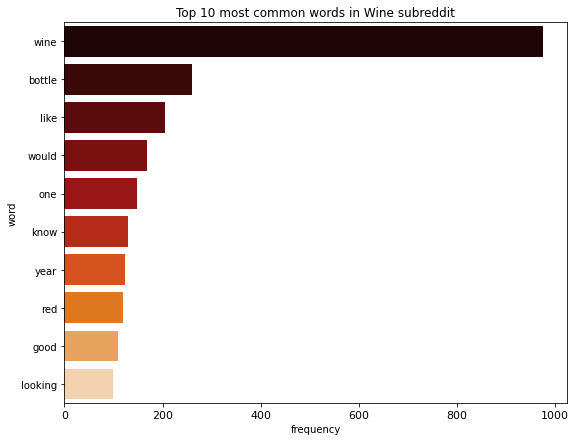

In [63]:
#create a bar chart for better visualization
plt.figure(figsize=(9,7))
sns.barplot(x='frequency', y='word', data=wine_freq[:10], palette='gist_heat', orient='h')
plt.title('Top 10 most common words in Wine subreddit')
plt.xticks(fontsize=11);

While 'wine' is the most common word in wine subreddit, the second most common word found in wine subreddit is 'bottle', which makes sense as wine is often packaged in bottle. The word 'like' is found as the top common word in wine subreddit as well. Other similar common words to beer subreddits include 'would', 'one', 'know', indicating how both subreddits share enough similarity to be used in classification model. At the same time, words such as 'red' and 'year' can be used to specifically identified that the post may be discussing about wine.

Now, we are assigning a label column of 0 to the wine dataset.

In [64]:
#generate label = 0 column to wine dataset
wine_merged['label'] = np.zeros(len(wine_merged))
wine_merged

,text,label
0,monthly wine challengemarch tasting note post,0.0
1,free talk friday,0.0
2,couple old alsatian bottle ren klein gewurztra...,0.0
3,sine qua non raven syrah,0.0
4,still thinking one last night melchor,0.0
...,...,...
970,hello wondering wine would pair best carmelize...,0.0
974,put ember mug say enjoy wine vapor inhalation ...,0.0
979,hi vino looking app practice study learn wine ...,0.0
981,hello finally wine cabinet store bottle long t...,0.0


Then, we save the clean processed data into csv file.

In [65]:
#save the clean wine_merged data into csv file
wine_merged.to_csv('./datasets/cleaned_wine_merged.csv', index=False)

### Merge beer and wine datasets into one dataframe

Now, we are preparing the dataset to be input for our model.

In [66]:
clean_beer = pd.read_csv('./datasets/cleaned_beer_merged.csv')
clean_wine = pd.read_csv('./datasets/cleaned_wine_merged.csv')

In [67]:
#concatnate two datasets for the model
df = pd.concat([clean_beer,clean_wine],axis=0)
df

,text,label
0,hello everyone would like know ipas get fruity...,1.0
1,fellow foothill drinker,1.0
2,resource obtaining international beer,1.0
3,cheapest craft beer website ship uk,1.0
4,located twin city metro mni call seasoned ish ...,1.0
...,...,...
1342,hello wondering wine would pair best carmelize...,0.0
1343,put ember mug say enjoy wine vapor inhalation ...,0.0
1344,hi vino looking app practice study learn wine ...,0.0
1345,hello finally wine cabinet store bottle long t...,0.0


In [68]:
#reset index
df.reset_index(drop=True, inplace=True)

In [69]:
#check null values
df.isnull().sum()

text     8
label    0
dtype: int64

In [70]:
#drop null values
df.dropna(inplace=True)

In [71]:
#check duplicate values
df.duplicated().sum()

6

In [72]:
#drop duplicate values
df.drop_duplicates(inplace=True)

In [73]:
df

,text,label
0,hello everyone would like know ipas get fruity...,1.0
1,fellow foothill drinker,1.0
2,resource obtaining international beer,1.0
3,cheapest craft beer website ship uk,1.0
4,located twin city metro mni call seasoned ish ...,1.0
...,...,...
2689,hello wondering wine would pair best carmelize...,0.0
2690,put ember mug say enjoy wine vapor inhalation ...,0.0
2691,hi vino looking app practice study learn wine ...,0.0
2692,hello finally wine cabinet store bottle long t...,0.0


Our final data has 2680 rows and 2 columns.

In [74]:
#save merged dataset into csv file
df.to_csv('./datasets/final_data.csv', index=False)

## Modeling

In [75]:
#Import relevant libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

### Train/Test Split

In [76]:
#define y and X
X = df['text']
y = df['label']

In [77]:
#create testing and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [78]:
#check data shape
print(X_train.shape)
print(X_test.shape)

(2010,)
(670,)


### Use CountVectorizer to transform text

In [79]:
# Instantiate CountVectorizer object
cvec = CountVectorizer(lowercase= False)

In [80]:
# Transform to tokenize the words  
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [81]:
# Convert X_train into a DataFrame
X_train_df = pd.DataFrame(X_train_cvec.toarray(),
                          columns=cvec.get_feature_names())
X_train_df

,aal,ab,abbey,ability,abinbev,abita,able,abroad,absolute,absolutely,...,zing,zipfer,zone,zoom,zoomed,zot,zraly,zucchini,zunews,zwiesel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# Convert X_test into a DataFrame
X_test_df = pd.DataFrame(X_test_cvec.toarray(),
                         columns=cvec.get_feature_names())

X_test_df

,aal,ab,abbey,ability,abinbev,abita,able,abroad,absolute,absolutely,...,zing,zipfer,zone,zoom,zoomed,zot,zraly,zucchini,zunews,zwiesel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Baseline Accuracy

We calculate the baseline accuracy to check if the created model performs better than the model without features.

In [83]:
y_train.value_counts(normalize=True)

0.0    0.501493
1.0    0.498507
Name: label, dtype: float64

Baseline accuracy shows that majority of class fall under beer subreddit which is class 0.

## Logistic Regression Model

First, we create a Logistic Regression Model with default hyperparameters.

In [84]:
#Instantiate the model
logreg = LogisticRegression()

In [85]:
#Fit the model
logreg.fit(X_train_cvec,y_train)

LogisticRegression()

In [86]:
#evaluate the score for training data
logreg.score(X_train_cvec,y_train)

0.9930348258706467

In [87]:
#evaluate the score for testing data
logreg.score(X_test_cvec,y_test)

0.9014925373134328

The model seems to be overfitted as the training data has higher accuracy score compared to testing data.

Let's take a look at confusion metrics

In [154]:
y_pred_logreg = logreg.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Negative:", tn)
print("False Positive:", fp)
print("True Positive:", tp)
print("False Negative:", fn)

True Negative: 312
False Positive: 24
True Positive: 320
False Negative: 14


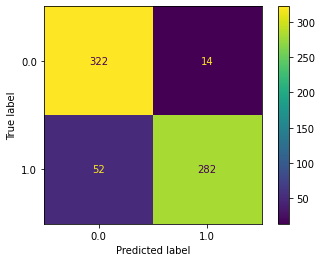

In [155]:
plot_confusion_matrix(logreg,X_test_cvec,y_test);

In [90]:
specificity = tn / (tn+fp) # How accurately can the model predict for the negative class
sensitivity = tp / (tp+fn) # How accurately can the model predict for the positive class
accruacy = (tp+tn) / (tp+tn+fp+fn) #How accurately did the model correctly predict?

print('Specficity:', round(specificity,2))
print('Sensitivity:',round(sensitivity,2))
print('Accuracy:',round(accruacy,2))

Specficity: 0.96
Sensitivity: 0.84
Accuracy: 0.9


From the above results, the model is more likely to accurately predict negative class than positive class. However, accuracy is a better evaluation metric in this case as we are trying to classify between two subreddit posts and there is no difference in consequences whether we have more False negative or False positive. From the model, we observe a total of 14+52 = 66 misclassified posts.

Now, let's create Naive Bayes Model to compared against this model.

## Multinomial Naive Bayes

We are using Multinomial Naive Bayes model as our discrete features (X) have countable values.

In [94]:
# Instantiate the model
mnb = MultinomialNB()

In [95]:
# Fit the training set
mnb.fit(X_train_cvec, y_train) 

MultinomialNB()

In [96]:
# Evaluate the score for training data
mnb.score(X_train_cvec, y_train)

0.9766169154228855

In [97]:
# Evaluate the score for testing data
mnb.score(X_test_cvec, y_test)

0.9432835820895522

Let's looking at confusion metrics

In [156]:
y_pred_nb = nb.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Negative:", tn)
print("False Positive:", fp)
print("True Positive:", tp)
print("False Negative:", fn)

True Negative: 312
False Positive: 24
True Positive: 320
False Negative: 14


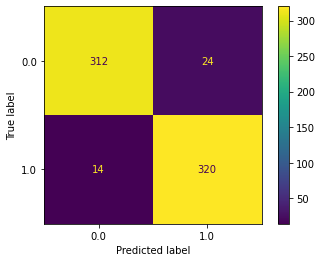

In [157]:
plot_confusion_matrix(nb,X_test_cvec,y_test);

In [100]:
specificity = tn / (tn+fp) # How accurately can the model predict for the negative class
sensitivity = tp / (tp+fn) # How accurately can the model predict for the positive class
accruacy = (tp+tn) / (tp+tn+fp+fn) #How accurately did the model correctly predict?

print('Specficity:', round(specificity,2))
print('Sensitivity:',round(sensitivity,2))
print('Accuracy:',round(accruacy,2))

Specficity: 0.93
Sensitivity: 0.96
Accuracy: 0.94


The accuracy for Naive Bayes model on testing data is slightly better than accuracy of Logistic Regression model (0.94 VS. 0.90). In this model, there are a total of 14+24 = 38 misclassified posts, which are also less than those of Logistic Regression model. While overall Naive Bayes model seems to be a better model than Logistic Regression, Naive Bayes model is still overfit. Therefore, we would like to optimize both models to find better accuracy scores.

## Optimizing Count Vectorizer

### 1. Logistic Regression Model

In [101]:
# Pipe to add the countvectorizer and logreg
pipe_logreg = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)), 
    ('logreg', logreg),
])

# Parameters to test the different hyperparameters
params_logreg = {
    'logreg__penalty':['l1','l2'],
    'logreg__solver': ['liblinear','sag','saga'], # Testing different algorithms
    'logreg__C': np.logspace(-5,0,100) # Different alpha values, which are regularization hyper parameters to reduce the model's overfitting
}

In [102]:
# Instantiate the GridSearchCV
gs_logreg = GridSearchCV(pipe_logreg,
                 param_grid=params_logreg,
                 cv=5,
                 verbose = 1,
                 n_jobs = -1)

In [103]:
# Fit the model
gs_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished
C:\Users\ACDMY8\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.0370172...
       1.09749877e-01, 1.23284674e-01, 1.38488637e-01, 1.55567614e-01,
       1.74752840e-01, 1.96304065e-01, 2.20513074e-01, 2.47707636e-01,
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear', 'sag', 'saga']},

In [104]:
# Find the best parameters
gs_logreg.best_params_

{'logreg__C': 0.10974987654930568,
 'logreg__penalty': 'l2',
 'logreg__solver': 'sag'}

In [105]:
# Best score
gs_logreg.best_score_

0.9189054726368159

In [106]:
# Accuracy score on the training data
gs_logreg.score(X_train, y_train)

0.9666666666666667

In [107]:
# Accuracy score the testing data
gs_logreg.score(X_test, y_test)

0.9149253731343283

The accuracy score improves slightly from the default model (0.90 VS 0.91).

### 2. Naive Bayes Model

In [134]:
# Pipe to add the countvectorizer and multinomial
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('mnb', MultinomialNB())
])

# Parameters to test the different hyper parameters
params_mnb = {
    'cvec__ngram_range': [(1,1),(2,2)], # Testing using unigrams bigrams
    'cvec__max_features': [8000, 9000, 10000], 
    'cvec__min_df': [1,2], # Minimum number of documents to include token
    'cvec__max_df': [.9, .95], # Maximum number of documents to include token
    'mnb__alpha':np.linspace(0.5, 1.5, 2), # Testing different alpha values
}

In [135]:
# Instantiate the GridSearchCV
gs_mnb = GridSearchCV(pipe_mnb,
                 param_grid=params_mnb,
                 cv=5,
                 verbose = 1,
                 n_jobs = -1)

In [136]:
# Fit the model
gs_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [8000, 9000, 10000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'mnb__alpha': array([0.5, 1.5])},
             verbose=1)

In [137]:
# Best parameters for the model
gs_mnb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 8000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'mnb__alpha': 0.5}

In [138]:
# Best model
gs_mnb.best_score_

0.9328358208955223

In [139]:
# Score against the training set
gs_mnb.score(X_train, y_train)

0.9796019900497512

In [140]:
# Score against the test set
gs_mnb.score(X_test, y_test)

0.9417910447761194

The Naive Bayes model's accuracy score does not improve compared to the default model. Now, we will try using TFIDF vectorizer for both models instead.

## Optimizing TFIDF Vectorizer

### 1. Logistic Regression Model

In [117]:
# Pipe to add the TFIDF vectorizer and logreg

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)), 
    ('logreg', logreg)
])

In [118]:
# Instantiate the GridSearchCV
gs_tvec_logreg = GridSearchCV(pipe_tvec,
                 param_grid=params_logreg,
                 cv=5,
                 verbose = 1,
                 n_jobs = -1)

In [119]:
# Fit the model
gs_tvec_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.0370172...
       1.09749877e-01, 1.23284674e-01, 1.38488637e-01, 1.55567614e-01,
       1.74752840e-01, 1.96304065e-01, 2.20513074e-01, 2.47707636e-01,
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear', 'sag', 'saga']},

In [120]:
# Best parameters for the model
gs_tvec_logreg.best_params_

{'logreg__C': 0.7924828983539169,
 'logreg__penalty': 'l2',
 'logreg__solver': 'saga'}

In [121]:
# Best model score
gs_tvec_logreg.best_score_

0.925870646766169

In [122]:
# Score against the training set
gs_tvec_logreg.score(X_train, y_train)

0.9875621890547264

In [123]:
# Score against the test set
gs_tvec_logreg.score(X_test, y_test)

0.9119402985074627

Using TFIDF, our logistic regression model's accuracy improved only slightly, but the model became more overfitted.

### 2. Naive Bayes Model

In [144]:
# Pipe to add the TFIDF vectorizer and multinomial
pipe_mnb = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('mnb', MultinomialNB())
])

params_mnb = {
    'tvec__ngram_range': [(1,1),(2,2)], # Testing using unigrams bigrams
    'tvec__max_features': [8000, 9000, 10000], 
    'tvec__min_df': [1,2], # Minimum number of documents to include token
    'tvec__max_df': [.9, .95], # Maximum number of documents to include token
    'mnb__alpha': np.linspace(0.5, 1.5, 2), # Testing different alpha values
}


In [145]:
# Instantiate the GridSearchCV
gs_tvec_mnb = GridSearchCV(pipe_mnb,
                 param_grid=params_mnb,
                 cv=5,
                 verbose = 1,
                 n_jobs = -1)

In [146]:
# Fit the model
gs_tvec_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mnb__alpha': array([0.5, 1.5]),
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [8000, 9000, 10000],
                         'tvec__min_df': [1, 2],
                         'tvec__ngram_range': [(1, 1), (2, 2)]},
             verbose=1)

In [147]:
# Best parameters for the model
gs_tvec_mnb.best_params_

{'mnb__alpha': 1.5,
 'tvec__max_df': 0.9,
 'tvec__max_features': 8000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [148]:
# Best model
gs_tvec_mnb.best_score_

0.9228855721393036

In [149]:
# Score against the training set
gs_tvec_mnb.score(X_train, y_train)

0.972139303482587

In [150]:
# Score against the test set
gs_tvec_mnb.score(X_test, y_test)

0.9313432835820895

The model's accuracy slightly dropped using TFIDF vectorizer. 

## Summary table of accuracy scores in each model

| Dataset | Type of vectorizer | Type of model | Accuracy Score |
|-|-|-|-|
| Train | Count Vectorizer (default) | Logistic Regresion | 0.993 |
| Test | Count Vectorizer (default) | Logistic Regresion | 0.901 |
| Train | Count Vectorizer (default) | Multinomial Naive Bayes | 0.976 |
| **Test** | **Count Vectorizer (default)** | **Multinomial Naive Bayes** | **0.943** |
| Train | Count Vectorizer (tuned) | Logistic Regresion | 0.966 |
| Test | Count Vectorizer (tuned) | Logistic Regresion | 0.914 |
| Train | Count Vectorizer (tuned) | Multinomial Naive Bayes | 0.979 |
| Test | Count Vectorizer (tuned) | Multinomial Naive Bayes | 0.941 |
| Train | TFIDF Vectorizer (tuned) | Logistic Regresion | 0.987 |
| Test | TFIDF Vectorizer (tuned) | Logistic Regresion | 0.911 |
| Train | TFIDF Vectorizer (tuned) | Multinomial Naive Bayes | 0.972 |
| Test | TFIDF Vectorizer (tuned) | Multinomial Naive Bayes | 0.931 |

Our Multinomial Naive Bayes model with count vectorizer gives the best accuracy score of 94.3%

## Deep dive into the best model

Because we use accuracy as our evaluation metrics, Multinomial Naive Bayes with the default parameter gives us the highest accuracy score of 94%. Now we want to look at probabilities and misclassified posts from that model.

In [151]:
#First, let's look at probability 
mnb_prob = pd.DataFrame({'Token':cvec.get_feature_names(),'Negative Class Prob':mnb.feature_log_prob_[0],
              'Positive Class Prob':mnb.feature_log_prob_[1]})
mnb_prob.head()

,Token,Negative Class Prob,Positive Class Prob
0,aal,-10.081676,-9.126560
1,ab,-10.081676,-9.126560
2,abbey,-10.081676,-8.838878
3,ability,-10.081676,-9.532025
4,abinbev,-10.081676,-9.126560


In [152]:
# Top log probabilities for the positive class, beer subreddit
mnb_prob.sort_values('Positive Class Prob', ascending=False)[['Token','Positive Class Prob']].head(10)

,Token,Positive Class Prob
558,beer,-3.369764
3633,like,-4.562212
4423,one,-5.269345
7202,would,-5.269345
3465,know,-5.290698
826,brewery,-5.297919
2696,get,-5.373142
265,anyone,-5.380985
1972,drink,-5.412988
2772,good,-5.412988


In [153]:
# Top log probabilities for the negative class, wine subreddit
mnb_prob.sort_values('Negative Class Prob', ascending=False)[['Token','Negative Class Prob']].head(10)

,Token,Negative Class Prob
7141,wine,-3.544984
759,bottle,-4.877669
3633,like,-5.098069
7202,would,-5.302552
4423,one,-5.418236
5221,red,-5.527799
1698,de,-5.604339
7229,year,-5.615767
3465,know,-5.627328
2772,good,-5.724967


We can conclude from the above tables that the higher the probability, the higher the importance of the feature corresponding to its class. In this case, "beer" 

Now, let's take a look at the misclassified posts.

In [158]:
# Index of Misclassified posts for the test set
index_misclassified_post = y_test[y_pred_nb != y_test].index
index_misclassified_post

Int64Index([ 945,  693, 2038, 2245,  339, 2323, 2122,  492,  170, 2180, 1979,
            1533, 1750,  337, 1261, 1199, 2579,  580, 2299, 2431, 2110, 1399,
            1974, 2362,  713, 2444, 2496, 1732, 1576, 2032,  961, 2611, 1746,
            2320,    1, 1348,   91,  208],
           dtype='int64')

In [162]:
# check if there are 38 misclassified posts
index_misclassified_post.shape

(38,)

In [160]:
# Creating the dataframe for the misclassified posts
mnb_misclassified_posts = pd.DataFrame(X_test[index_misclassified_post])
mnb_misclassified_posts

,text
945,high price
693,dry january
2038,anyone information symbol nd pic date
2245,topcover green yellow lone happy cow
339,cervesas missing
2323,beautiful day neighborhood
2122,drink
492,recommendation maibocks
170,kilkenny
2180,explain biodynamics guest


In [163]:
# Getting the frequency of the words that are misclassified as beer label
misclassified_words = mnb_misclassified_posts['text'].str.cat(sep=' ')

misclassified_words_dict = {}
for word in misclassified_words.split():
    if word in misclassified_words_dict:
        misclassified_words_dict[word] = misclassified_words_dict[word] + 1
    else:
        misclassified_words_dict[word] = 1

In [164]:
misclassified_words_freq = pd.DataFrame(misclassified_words_dict.values(), 
             index=misclassified_words_dict.keys(),
             columns=['Frequency']).sort_values('Frequency',ascending=False)

# Top 10 words that were in misclassified posts
misclassified_words_freq.head(10)

,Frequency
wine,10
know,7
help,6
like,6
bottle,5
anyone,5
need,5
something,4
drink,4
juice,3


From the table above, "wine" is the top word that was in misclassified posts, followed by "know" and "help". Even though "wine" should be the most useful feature in terms of differentiating the subreddit, the feature might be less useful in some cases hence the model couldn't use it to classify the post. Further investigation is needed in order to improve our model.

## Conclusion and Recommendation

With our objective of finding the best classification model to differentiate wine subreddit posts to beer subreddit posts, we found that our default Multinomial Naive Bayes model with count vectorizer gives the best accuracy score of 94.3%. I concluded that the best model for my Startup to proceed for further development would be Multinomial Naive Bayes model with default hyperparameters and count vectorizer.


### Key Findings:
- While both subreddits have heavy right-skewed graph, titles in wine subreddit seems to be shorter than those of beer subreddit. With not significant difference in number of words in titles, both subreddits are similarly verbose.
- The most popular time for posting on wine subreddit is 8pm, which is a lot earlier than the most popular time for posting on beer subreddit of 2am. Wine subreddit appears to be less active compared to beer subreddit as number of posts are under 20 posts per hour majority of the time while Beer subreddit has more 20 posts per hour majority of the time.
- As this beer subreddit is created to "discuss your favorite beers and breweries, and share beer related articles", it is not surprising to see the word 'beer' as the most common word, followed by 'like' being the second most common word here. Then, there is a drop after the word 'like' as other common words such as 'know', 'would', 'one', and 'anyone' occuring in range of 200. From these top common words, it is likely that majority of posts ask questions on what/where to find good brewery/drink.
- While 'wine' is the most common word in wine subreddit, the second most common word found in wine subreddit is 'bottle', which makes sense as wine is often packaged in bottle. The word 'like' is found as the top common word in wine subreddit as well. Other similar common words to beer subreddits include 'would', 'one', 'know', indicating how both subreddits share enough similarity to be used in classification model. At the same time, words such as 'red' and 'year' can be used to specifically identified that the post may be discussing about wine.


### Recommendations:
Moving forward, steps that I can take to tune and tweak my model for better accuracy score would be to:
- Feature engineer more features such as characters or word lengths
- Explore other features that could play significant role in predicting outcome such as post comments
- Try using other models such as Decision Trees, Random Forests
- Hypertune my classifier again to reduce overfitting 
- Try adding the keyword "wine" and "beer" to the list of stopwords to see how well the model can classify without these key predictors
- Create my own list of stop words such as "bottle", "anyone"
- Explore more evaluation metrics apart from accuracy score such as ROC AUC score
- Try collecting more data
